## Importaciones

En esta celda se importan todas las librerías necesarias para construir, entrenar y evaluar el modelo:

- **`torch`, `torch.nn as nn`, `torch.optim as optim`**:
  - Proporcionan las herramientas principales de PyTorch.
  - `nn` se usa para definir capas de redes neuronales (por ejemplo, `nn.LSTM`, `nn.Linear`, `nn.Dropout`).
  - `optim` contiene los optimizadores como `Adam`, `SGD`, etc.

- **`from torch.utils.data import DataLoader, TensorDataset`**:
  - `TensorDataset` permite empaquetar los tensores de entrada y salida en un dataset.
  - `DataLoader` gestiona la carga de datos en mini-batches y el barajado de los mismos durante el entrenamiento.

- **`import pandas as pd`**:
  - Se usa para cargar y manipular datos tabulares desde archivos CSV en estructuras tipo `DataFrame`.

- **`import numpy as np`**:
  - Se utiliza para operaciones numéricas generales y manejo de arrays.

- **`import joblib`**:
  - Permite cargar objetos serializados (por ejemplo, los escaladores `scaler_features` y `scaler_target` guardados previamente).

- **`import matplotlib.pyplot as plt`**:
  - Se usa para crear gráficos, como la evolución de la pérdida, o comparar valores reales frente a predicciones.

- **`from sklearn.metrics import mean_absolute_error, mean_squared_error`**:
  - Proporciona métricas de evaluación:
    - `mean_absolute_error (MAE)`: error absoluto medio.
    - `mean_squared_error (MSE)`: error cuadrático medio (del que se puede obtener el `RMSE` aplicando la raíz cuadrada).

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Configuración del dispositivo (CPU / GPU)

Configuración del dispositivo de cómputo:

- **Selección del dispositivo**:

  `device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')`

In [34]:
# 1. Configuración y Carga de Datos
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


- **`torch.manual_seed(30)`**:
  - Fija la semilla para las operaciones aleatorias internas de PyTorch, como la inicialización de pesos o el barajado de datos dentro de `DataLoader` (cuando corresponde).

- **`np.random.seed(30)`**:
  - Fija la semilla para las operaciones aleatorias realizadas con NumPy.

**Objetivo**:

- Conseguir que los experimentos sean lo más **reproducibles** posible.
- Si se vuelve a ejecutar el notebook con la misma configuración y datos, los resultados (pérdidas, métricas de evaluación, etc.) deberían ser muy similares.

In [35]:
torch.manual_seed(30)
np.random.seed(30)


## Carga del dataset y creación de lags
En esta celda se carga el conjunto de datos ya normalizado y se añaden variables de retardo (`lags`) del precio, además de cargar los escaladores usados en el preprocesado.

- **Carga del dataset normalizado**:

    df = pd.read_csv('data/processed/Dataset_PVPC_Normalizado.csv')

  - Se obtiene un `DataFrame` con:
    - La variable objetivo `price` (normalizada).
    - Variables meteorológicas (`temperature_2m (°C)`, `cloud_cover (%)`, `wind_speed_100m (km/h)`, etc.).
    - Variables de calendario (`hour_sin`, `hour_cos`, `day_sin`, `day_cos`, `month_sin`, `month_cos`, `no_laborable`).
    - Más adelante se añadirán las columnas de precio retardado.

- **Carga de los escaladores**:

 `scaler_features = joblib.load('artifacts/scaler_features.pkl')`
 
  `scaler_target = joblib.load('artifacts/scaler_target.pkl')`

In [36]:
# Cargar dataset y scalers
df = pd.read_csv('data/processed/Dataset_PVPC_Normalizado.csv')
scaler_features = joblib.load('artifacts/scaler_features.pkl')
scaler_target = joblib.load('artifacts/scaler_target.pkl')
df['price_lag_1'] = df['price'].shift(1)
df['price_lag_24'] = df['price'].shift(24)
df['price_lag_168'] = df['price'].shift(168) # Misma hora, semana anterior
df.dropna(inplace=True)

In [37]:
# visualización del df
df

,price,temperature_2m (°C),cloud_cover (%),wind_speed_100m (km/h),shortwave_radiation (W/m²),apparent_temperature (°C),direct_radiation (W/m²),diffuse_radiation (W/m²),wind_gusts_10m (km/h),relative_humidity_2m (%),hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,no_laborable,price_lag_1,price_lag_24,price_lag_168
168,0.363691,0.055248,0.192766,0.339216,0.000000,0.046589,0.000000,0.000000,0.190136,0.742481,0.500000,1.000000,0.500000,1.000000,0.75,0.933013,0.0,0.371353,0.372190,0.306377
169,0.356933,0.044494,0.181489,0.315398,0.000000,0.036844,0.000000,0.000000,0.179591,0.745927,0.629410,0.982963,0.500000,1.000000,0.75,0.933013,0.0,0.363691,0.367907,0.305240
170,0.347230,0.051438,0.218723,0.299026,0.000000,0.043086,0.000000,0.000000,0.185083,0.724311,0.750000,0.933013,0.500000,1.000000,0.75,0.933013,0.0,0.356933,0.359509,0.300254
171,0.345523,0.037549,0.208936,0.282654,0.000000,0.031643,0.000000,0.000000,0.166850,0.735589,0.853553,0.853553,0.500000,1.000000,0.75,0.933013,0.0,0.347230,0.355494,0.303199
172,0.356665,0.024582,0.275745,0.260876,0.000000,0.020530,0.000000,0.000000,0.157330,0.750313,0.933013,0.750000,0.500000,1.000000,0.75,0.933013,0.0,0.345523,0.355126,0.307582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8778,0.854390,0.142699,0.124255,0.125975,0.042631,0.162050,0.028531,0.054453,0.062720,0.757832,0.000000,0.500000,0.900969,0.801938,0.50,1.000000,0.0,0.834181,0.875468,0.688604
8779,0.842244,0.110927,0.130851,0.119141,0.000180,0.131775,0.000052,0.000402,0.024385,0.816103,0.017037,0.629410,0.900969,0.801938,0.50,1.000000,0.0,0.854390,0.900127,0.677998
8780,0.832675,0.087205,0.141915,0.122150,0.000000,0.107303,0.000000,0.000000,0.033575,0.848997,0.066987,0.750000,0.900969,0.801938,0.50,1.000000,0.0,0.842244,0.880956,0.649993
8781,0.646748,0.065757,0.176596,0.140460,0.000000,0.083653,0.000000,0.000000,0.051882,0.869674,0.146447,0.853553,0.900969,0.801938,0.50,1.000000,0.0,0.832675,0.669566,0.503011


## Definición de `X` (features) e `y` (target)

Se seleccionan las columnas que formarán parte de las características de entrada (`X`) y la variable objetivo (`y`).

In [38]:
# La red NECESITA la curva de precios pasada para predecir el futuro.
feature_cols = list(df.columns)
X_data = df[feature_cols].values
y_data = df['price'].values

## Función `create_sequences` y generación de secuencias

Se define una función que construye las secuencias temporales que usará la LSTM, y luego se aplica dicha función sobre los datos.

- **`seq_length`**:
  - Es la longitud de la ventana temporal que verá la LSTM.
  - En este caso, `SEQ_LENGTH = 24`, por lo que se usan las últimas 24 horas como entrada para predecir la siguiente hora.

- **Bucle sobre los índices**:

  - Para cada `i` desde `0` hasta `len(X) - seq_length - 1`:
    - `x = X[i:(i + seq_length)]`:
      - Es una submatriz de forma `(seq_length, num_features)` que representa el historial desde el tiempo `i` hasta `i + seq_length - 1`.
    - `y[i + seq_length]`:
      - Es el valor de `price` en el instante **justo después** de la ventana (el “paso futuro” a predecir).

- **Salida**:

  - `X_seq`:
    - Array NumPy de forma aproximada `(num_samples, seq_length, num_features)`.
    - Cada elemento es una secuencia de 24 pasos con todas las características.
  - `y_seq`:
    - Vector de longitud `num_samples` con el precio (normalizado) a predecir para cada secuencia.

In [39]:
def create_sequences(X, y, seq_length):
    xs, ys = [], []
    for i in range(len(X) - seq_length):
        x = X[i:(i + seq_length)] # Contiene historial hasta t-1 (incluyendo el precio)
        xs.append(x)
        ys.append(y[i + seq_length]) # El objetivo es t
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 24
X_seq, y_seq = create_sequences(X_data, y_data, SEQ_LENGTH)

## División Train / Validación / Test y `DataLoader`s

En esta celda se divide el dataset secuencial en conjuntos de entrenamiento, validación y test, respetando el orden temporal, y se crean los `DataLoader` para PyTorch.

In [40]:
train_split = int(len(X_seq) * 0.70)
val_split = int(len(X_seq) * 0.85)

X_train, y_train = X_seq[:train_split], y_seq[:train_split]
X_val, y_val = X_seq[train_split:val_split], y_seq[train_split:val_split]
X_test, y_test = X_seq[val_split:], y_seq[val_split:]

train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train)), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val)), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test)), batch_size=64, shuffle=False)

## Definición del modelo `LSTMModel` e instanciación

En esta celda se define la arquitectura de la red neuronal basada en LSTM y se crea una instancia del modelo.

- **Parámetros principales**:
  - `input_size`: número de características de entrada por paso temporal (igual al número de columnas de `df`).
  - `hidden_size`: tamaño del estado oculto de la LSTM.
  - `num_layers`: número de capas LSTM apiladas.
  - `output_size`: tamaño de la salida (1, porque se predice un único valor de precio).
  

In [41]:
from src.lstm_model import LSTMModel

model = LSTMModel(
    input_size=len(feature_cols),
    hidden_size=128,
    num_layers=2,
    output_size=1,
    dropout=0.2,
    bidirectional=True,
).to(device)

## Entrenamiento

**Configuración inicial**:

- `criterion = nn.MSELoss()`: Función de pérdida (Error Cuadrático Medio). Mide cuánto se alejan las predicciones de los valores reales
- `optimizer = optim.Adam(...)`: Optimizador Adam que ajusta pesos para minimizar la pérdida
    - `lr=1e-2 (0.01)`: Tasa de aprendizaje
    - `weight_decay=1e-5`: Regularización L2, que penaliza pesos grandes para evitar overfitting
- `scheduler = optim.lr_scheduler.ReduceLROnPlateau(...)`: Reduce la tasa de aprendizaje si la validación no mejora
    - `mode='min'`: Busca minimizar la pérdida
    - `factor=0.5`: Multiplica la tasa de aprendizaje por 0.5 cuando se dispara
    - `patience=3`: Espera 3 épocas sin mejora antes de reducir

**Inicialización**:

- `train_losses = [], val_losses = []`: Listas para registrar pérdidas históricas


**Bucle principal - Entrenamiento**:

- `for epoch in range(epochs):`: Itera 75 veces
- `model.train()`: Activa el modo entrenamiento (regularización activa)
- `train_loss = 0`: Acumulador de pérdida
- `for batch_X, batch_y in train_loader:`: Itera sobre minilotes del conjunto de entrenamiento
  - `batch_X, batch_y = batch_X.to(device), batch_y.to(device)`: Mueve los tensores al dispositivo (GPU/CPU)
  - `optimizer.zero_grad()`: Limpia los gradientes del optimizador (necesario antes de calcular nuevos gradientes)
  - `outputs = model(batch_X)`: Predicción del modelo. Forma: (batch, 1)
  - `loss = criterion(outputs.squeeze(), batch_y)`: Calcula MSE
    - `.squeeze()` elimina dimensiones de tamaño 1, convirtiendo de (batch, 1) a (batch,)
  - `loss.backward()`: Calcula gradientes usando backpropagation
  - `optimizer.step()`: Actualiza los pesos basado en los gradientes
  - `train_loss += loss.item()`: Acumula la pérdida de este minilote


**Evaluación en validación**:

- `model.eval()`: Activa el modo evaluación (regularización desactivada)
- `val_loss = 0`: Acumulador
- `with torch.no_grad():`: Desactiva el cálculo de gradientes para ahorrar memoria
- `for batch_X, batch_y in val_loader:`: Itera sobre minilotes de validación
  - Mismo proceso pero sin backward() ni optimizer.step() (solo predicción)
  - `val_loss += loss.item()`: Acumula


**Actualización del scheduler y registro**:

- `avg_train = train_loss/len(train_loader)`: Promedia la pérdida de entrenamiento
- `avg_val = val_loss/len(val_loader)`: Promedia la pérdida de validación
- `scheduler.step(avg_val)`: Ajusta la tasa de aprendizaje si es necesario
- `train_losses.append(avg_train), val_losses.append(avg_val)`: Almacena para graficar
- `if (epoch+1) % 5 == 0:`: Imprime cada 5 épocas

In [42]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5) # L2 Regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

train_losses = []
val_losses = []

epochs = 75
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    # Evaluar en Validación
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            val_loss += loss.item()

    avg_train = train_loss/len(train_loader)
    avg_val = val_loss/len(val_loader)
    scheduler.step(avg_val)

    train_losses.append(avg_train)
    val_losses.append(avg_val)

    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train:.5f} | Val Loss: {avg_val:.5f}")

Epoch [5/75] | Train Loss: 0.00396 | Val Loss: 0.00445
Epoch [10/75] | Train Loss: 0.00354 | Val Loss: 0.00547
Epoch [15/75] | Train Loss: 0.00316 | Val Loss: 0.00366
Epoch [20/75] | Train Loss: 0.00267 | Val Loss: 0.00648
Epoch [25/75] | Train Loss: 0.00291 | Val Loss: 0.00376
Epoch [30/75] | Train Loss: 0.00177 | Val Loss: 0.00230
Epoch [35/75] | Train Loss: 0.00171 | Val Loss: 0.00230
Epoch [40/75] | Train Loss: 0.00163 | Val Loss: 0.00224
Epoch [45/75] | Train Loss: 0.00147 | Val Loss: 0.00256
Epoch [50/75] | Train Loss: 0.00129 | Val Loss: 0.00198
Epoch [55/75] | Train Loss: 0.00126 | Val Loss: 0.00202
Epoch [60/75] | Train Loss: 0.00124 | Val Loss: 0.00192
Epoch [65/75] | Train Loss: 0.00129 | Val Loss: 0.00196
Epoch [70/75] | Train Loss: 0.00118 | Val Loss: 0.00191
Epoch [75/75] | Train Loss: 0.00114 | Val Loss: 0.00191


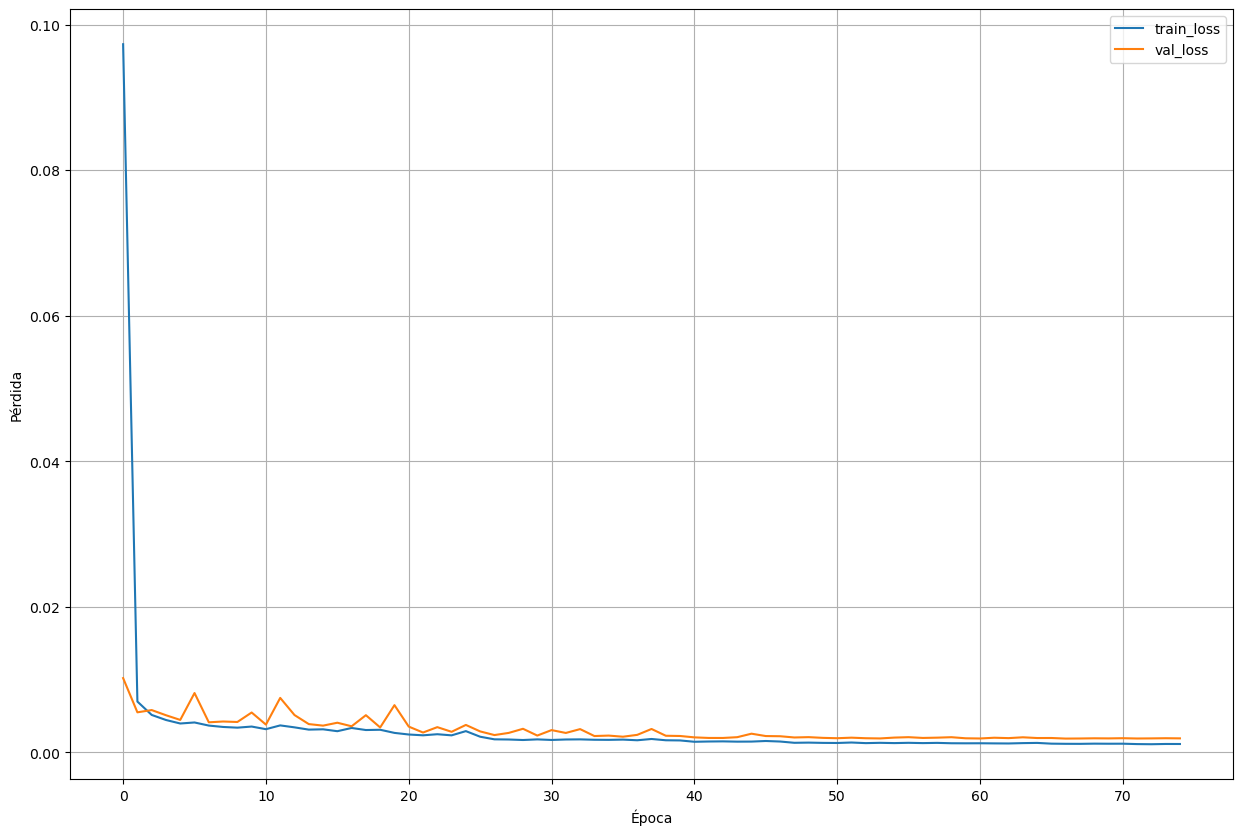

In [43]:
# visualizacion entrenamiento
plt.figure(figsize=(15, 10))
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

## Denormalización

El objetivo es convertir las predicciones normalizadas a valores reales en €/MWh.

In [44]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(batch_y.numpy())

In [45]:
# invertir la normalización para obtener precios reales (Euros/MWh)
# scaler_target espera un array 2D
predictions_rescaled = scaler_target.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals_rescaled = scaler_target.inverse_transform(np.array(actuals).reshape(-1, 1))

## Cálculo de métricas

`mean_absolute_error(actuals_rescaled, predictions_rescaled)`: Calcula MAE

**MAE (Error Absoluto Medio)**: Promedio de las diferencias absolutas

`mean_squared_error(actuals_rescaled, predictions_rescaled)`: Calcula MSE

**MSE (Error Cuadrático Medio)**: Promedio de diferencias al cuadrado

`np.sqrt(...)`: Saca la raíz cuadrada para obtener RMSE

**RMSE (Raíz del Error Cuadrático Medio)**: Raíz cuadrada del MSE

In [46]:
mae = mean_absolute_error(actuals_rescaled, predictions_rescaled)
rmse = np.sqrt(mean_squared_error(actuals_rescaled, predictions_rescaled))

print("\n--- Resultados de la Evaluación ---")
print(f"MAE: {mae:.4f} €/MWh")
print(f"RMSE: {rmse:.4f} €/MWh")


--- Resultados de la Evaluación ---
MAE: 10.9878 €/MWh
RMSE: 14.6361 €/MWh


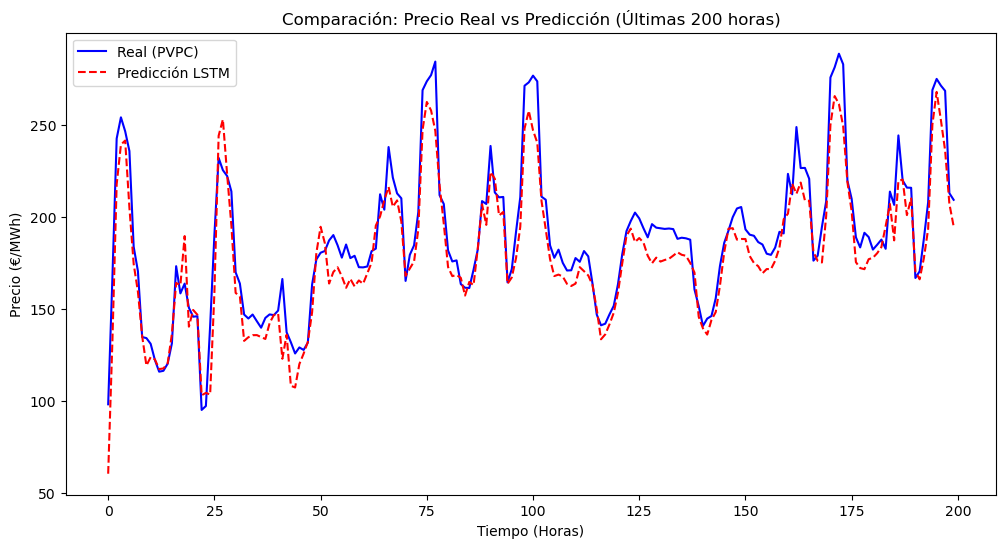

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(actuals_rescaled[-200:], label='Real (PVPC)', color='blue')
plt.plot(predictions_rescaled[-200:], label='Predicción LSTM', color='red', linestyle='--')
plt.title('Comparación: Precio Real vs Predicción (Últimas 200 horas)')
plt.xlabel('Tiempo (Horas)')
plt.ylabel('Precio (€/MWh)')
plt.legend()
plt.show() 

In [ ]:
# guardar el modelo
torch.save(model.state_dict(), 'artifacts/modelo_lstm_pvpc.pth')